In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("FATAL")

21/08/02 15:33:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/02 15:33:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/08/02 15:33:11 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
from utility import *
import pyspark.sql.functions as F
from pyspark.sql import Window

In [3]:
# Read in AP Data
df_radio5 = spark.read.csv('neighbor_data/radio_5_neighbors.csv', header=True, inferSchema=True, sep="|").limit(100000)
df_radio5 = df_radio5.filter('erm__neighbors is not Null')

df_radio24 = spark.read.csv('neighbor_data/radio_24_neighbors.csv', header=True, inferSchema=True, sep="|").limit(100000)
df_radio24 = df_radio24.filter('erm__neighbors is not Null')

In [4]:
# Filter data (remove alphabetical values in numerical column)
from pyspark.sql.functions import *

df_radio5 = df_radio5.filter(~F.col('erm__current_channel_usage__ibss').rlike('[a-zA-Z]'))
df_radio5 = df_radio5.filter(~F.col('erm__current_channel_usage__obss').rlike('[a-zA-Z]'))
df_radio5 = df_radio5.filter(~F.col('erm__current_channel_usage__interference').rlike('[a-zA-Z]'))

df_radio24 = df_radio24.filter(~F.col('erm__current_channel_usage__ibss').rlike('[a-zA-Z]'))
df_radio24 = df_radio24.filter(~F.col('erm__current_channel_usage__obss').rlike('[a-zA-Z]'))
df_radio24 = df_radio24.filter(~F.col('erm__current_channel_usage__interference').rlike('[a-zA-Z]'))

In [5]:
# Append neighbor_counts column to dataframe
from pyspark.sql.types import IntegerType
udf_get_neighbor_counts = F.udf(lambda neighbors: len(eval(neighbors)), IntegerType())

df_radio5 = df_radio5.withColumn('neighbor_counts', udf_get_neighbor_counts(F.col('erm__neighbors')))
df_radio24 = df_radio24.withColumn('neighbor_counts', udf_get_neighbor_counts(F.col('erm__neighbors')))

In [6]:
# Get customer values from csv files
import os
path = 'Updated_WiFi_2/'
id_list = []
fileList = os.listdir(path)
for f in fileList:
    df_wifi = spark.read.csv('{}{}'.format(path, f), header=True, inferSchema=True, sep=",", nanValue='', nullValue='')
    df_wifi = df_wifi.na.replace('No', None)
    df_wifi = df_wifi.filter('customer is not Null')
    ids = list(df_wifi.select('customer').toPandas()['customer'])
    id_list.extend(ids)

In [8]:
# Add label column
from pyspark.sql.types import IntegerType
def checkID(id):
    return 1 if id in id_list else 0
        
udf_get_label = F.udf(lambda id: checkID(id), IntegerType())
df_radio5 = df_radio5.withColumn('label', udf_get_label(F.col('customer')))
df_radio24 = df_radio24.withColumn('label', udf_get_label(F.col('customer')))

In [9]:
df_5 = df_radio5
df_24 = df_radio24

In [10]:
# Drop unnecessary columns as clustering only takes in numerical features
cols_to_drop = ['erm__neighbors']
df_5 = df_5.drop(*cols_to_drop)
df_24 = df_24.drop(*cols_to_drop)

In [11]:
# Cast String columns to Integer so clustering works
from pyspark.sql.types import IntegerType
for str_column in df_24.columns[2:-1]:
    df_5 = df_5.withColumn(str_column, F.col(str_column).cast(IntegerType()))
    df_24 = df_24.withColumn(str_column, F.col(str_column).cast(IntegerType()))

In [12]:
# Rename columns to prepare for merging dataframes
for c in df_5.columns[1:]:
    df_5 = df_5.withColumnRenamed(c, c + "_5")

for c in df_24.columns[1:]:
    df_24 = df_24.withColumnRenamed(c, c + "_24")

In [13]:
df_5 = df_5.filter(df_5.id_5 != '000000000000')
df_24 = df_24.filter(df_24.id_24 != '000000000000')

In [14]:
df_5.printSchema()
df_24.printSchema()

root
 |-- customer: string (nullable = true)
 |-- id_5: string (nullable = true)
 |-- erm__current_channel_usage__ibss_5: integer (nullable = true)
 |-- erm__current_channel_usage__obss_5: integer (nullable = true)
 |-- erm__current_channel_usage__interference_5: integer (nullable = true)
 |-- erm__current_channel_usage__noise_floor_5: integer (nullable = true)
 |-- neighbor_counts_5: integer (nullable = true)
 |-- label_5: integer (nullable = true)

root
 |-- customer: string (nullable = true)
 |-- id_24: string (nullable = true)
 |-- erm__current_channel_usage__ibss_24: integer (nullable = true)
 |-- erm__current_channel_usage__obss_24: integer (nullable = true)
 |-- erm__current_channel_usage__interference_24: integer (nullable = true)
 |-- erm__current_channel_usage__noise_floor_24: integer (nullable = true)
 |-- neighbor_counts_24: integer (nullable = true)
 |-- label_24: integer (nullable = true)



In [15]:
# Merge 5 GHz and 2.4 GHz neighbors dataframes
df = mergeDataFrames(df_5, df_24, 'customer')
df = df.select('customer', 'id_5', 'id_24', 'erm__current_channel_usage__ibss_5', 'erm__current_channel_usage__ibss_24', 'erm__current_channel_usage__obss_5', 'erm__current_channel_usage__obss_24', 'erm__current_channel_usage__interference_5', 'erm__current_channel_usage__interference_24', 'erm__current_channel_usage__noise_floor_5', 'erm__current_channel_usage__noise_floor_24', 'neighbor_counts_5', 'neighbor_counts_24', 'label_5', 'label_24' )
df.printSchema()
df = df.na.replace('No', None)
df = df.na.drop()
# df.limit(5).toPandas()

root
 |-- customer: string (nullable = true)
 |-- id_5: string (nullable = true)
 |-- id_24: string (nullable = true)
 |-- erm__current_channel_usage__ibss_5: integer (nullable = true)
 |-- erm__current_channel_usage__ibss_24: integer (nullable = true)
 |-- erm__current_channel_usage__obss_5: integer (nullable = true)
 |-- erm__current_channel_usage__obss_24: integer (nullable = true)
 |-- erm__current_channel_usage__interference_5: integer (nullable = true)
 |-- erm__current_channel_usage__interference_24: integer (nullable = true)
 |-- erm__current_channel_usage__noise_floor_5: integer (nullable = true)
 |-- erm__current_channel_usage__noise_floor_24: integer (nullable = true)
 |-- neighbor_counts_5: integer (nullable = true)
 |-- neighbor_counts_24: integer (nullable = true)
 |-- label_5: integer (nullable = true)
 |-- label_24: integer (nullable = true)



In [16]:
df_pd = df.toPandas()

In [17]:
df_pd.head()

,customer,id_5,id_24,erm__current_channel_usage__ibss_5,erm__current_channel_usage__ibss_24,erm__current_channel_usage__obss_5,erm__current_channel_usage__obss_24,erm__current_channel_usage__interference_5,erm__current_channel_usage__interference_24,erm__current_channel_usage__noise_floor_5,erm__current_channel_usage__noise_floor_24,neighbor_counts_5,neighbor_counts_24,label_5,label_24
0,3b2ed110-59d9-11e9-b2eb-097690af9635,E43ED7D07705,E43ED7D07706,3,13,1,13,12,17,-93,-82,43,70,0,0
1,c45af140-2b6f-11ea-925c-cb4788700b86,F08620A246F6,F08620A246F4,0,13,0,10,0,14,-96,-85,13,40,0,0
2,5a4fe380-388d-11e9-88f4-6f9acfcffd90,D463FEE9EDBD,D463FEE9EDBE,2,6,2,16,14,13,-93,-78,101,89,0,0
3,e36e7de0-c350-11e9-ac21-ad5d367e4a53,488D3601041A,488D3601041B,5,6,10,9,4,13,-94,-80,63,91,0,0
4,540c3bc0-fc4d-11e9-a5b9-2f5c5fe06d2e,F086202D902C,F086202D902A,0,4,2,12,0,17,-95,-81,37,97,0,0


In [18]:
# Create dictionary to map customer --> ids and id --> customer
customers = df_pd['customer'].to_list()
ids_5 = df_pd['id_5'].to_list()
ids_24 = df_pd['id_24'].to_list()

from collections import defaultdict
customer_id_dict_5 = defaultdict(set)
customer_id_dict_24 = defaultdict(set)
id_customer_dict_5 = defaultdict(set)
id_customer_dict_24 = defaultdict(set)

for customer, id_5, id_24 in zip(customers, ids_5, ids_24):
    customer_id_dict_5[customer].add(id_5)
    customer_id_dict_24[customer].add(id_24)
    id_customer_dict_5[id_5].add(customer)
    id_customer_dict_24[id_24].add(customer)

# 2D list of ids (each element contains id array)
id_list_5 = []
id_list_24 = []
for x in range(len(customer_id_dict_5)):
    id_list_5.append(list(customer_id_dict_5[list(customer_id_dict_5.keys())[x]]))
for x in range(len(customer_id_dict_24)):
    id_list_24.append(list(customer_id_dict_24[list(customer_id_dict_24.keys())[x]]))

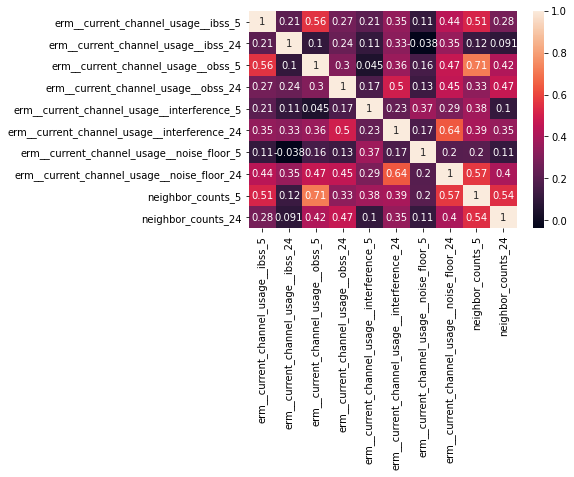


erm__current_channel_usage__ibss_5  erm__current_channel_usage__ibss_5             1.000000
                                    erm__current_channel_usage__ibss_24            0.210180
                                    erm__current_channel_usage__obss_5             0.555081
                                    erm__current_channel_usage__obss_24            0.266762
                                    erm__current_channel_usage__interference_5     0.206790
                                                                                     ...   
neighbor_counts_24                  erm__current_channel_usage__interference_24    0.350812
                                    erm__current_channel_usage__noise_floor_5      0.109215
                                    erm__current_channel_usage__noise_floor_24     0.402692
                                    neighbor_counts_5                              0.544222
                                    neighbor_counts_24                         

In [19]:
# Calculate correlation matrix for df
correlatedFeatures = getCorrelation(df, df.columns[3:-2], threshold=1)

In [149]:
df = df.drop(*['erm__current_channel_usage__ibss_5', 'erm__current_channel_usage__ibss_24'])

In [272]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

feature_columns = df.columns[3:-2]

assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")
scaler = StandardScaler(inputCol='features',outputCol='scaled_features')
minmaxScaler = MinMaxScaler(inputCol='features',outputCol='scaled_features')

kmeans = KMeans(featuresCol='scaled_features', k=2)

pipeline = Pipeline(stages=[assembler, minmaxScaler])
pipelineModel = pipeline.fit(df)

scaledDF = pipelineModel.transform(df)

kmModel = kmeans.fit(scaledDF)
results = kmModel.transform(scaledDF)

In [273]:
# results.limit(5).toPandas()

In [152]:
results.groupBy('prediction').count().toPandas() 

,prediction,count
0,1,29603
1,2,9223
2,0,28621


In [274]:
cluster0 = filterDataFrame(results, ['prediction == 0'])
cluster1 = filterDataFrame(results, ['prediction == 1'])
# cluster2 = filterDataFrame(results, ['prediction == 2'])

In [24]:
cluster0.groupBy('label_5').count().toPandas() 

,label_5,count
0,1,431
1,0,17910


In [25]:
cluster1.groupBy('label_5').count().toPandas() 

,label_5,count
0,1,1154
1,0,47952


In [144]:
getNumericalValues(cluster0, cluster0.columns[1:-3])

,summary,id_5,id_24,erm__current_channel_usage__ibss_5,erm__current_channel_usage__ibss_24,erm__current_channel_usage__obss_5,erm__current_channel_usage__obss_24,erm__current_channel_usage__interference_5,erm__current_channel_usage__interference_24,erm__current_channel_usage__noise_floor_5,erm__current_channel_usage__noise_floor_24,neighbor_counts_5,neighbor_counts_24,label_5,label_24
0,count,28770,28770,28770,28770,28770,28770,28770,28770,28770,28770,28770,28770,28770,28770
1,mean,None,None,2.7772332290580466,12.615224191866528,6.523774765380605,13.349287452207161,4.775217240180744,21.731039277024678,-93.82638164754952,-79.05811609315259,62.50281543274244,95.85199860966284,0.02415710809871394,0.02415710809871394
2,stddev,None,None,2.5277994013599345,5.497067659413142,4.88545223871685,4.056943777211577,7.318635282302593,8.603021823441836,3.475430696249936,3.7604724401885474,25.311564939423285,23.089450614449053,0.15353944651064194,0.15353944651064194
3,min,04A222271F1C,04A222271F1D,0,0,0,0,0,0,-110,-95,1,2,0,0
4,max,F85B3BDBA6F3,F08620A5434C,68,45,57,45,100,99,0,-53,134,256,1,1


In [27]:
# graphNumericalFeatures(cluster0, cluster0.columns[1:-3])

In [145]:
getNumericalValues(cluster1, cluster1.columns[1:-3])

,summary,id_5,id_24,erm__current_channel_usage__ibss_5,erm__current_channel_usage__ibss_24,erm__current_channel_usage__obss_5,erm__current_channel_usage__obss_24,erm__current_channel_usage__interference_5,erm__current_channel_usage__interference_24,erm__current_channel_usage__noise_floor_5,erm__current_channel_usage__noise_floor_24,neighbor_counts_5,neighbor_counts_24,label_5,label_24
0,count,29388,29388,29388,29388,29388,29388,29388,29388,29388,29388,29388,29388,29388,29388
1,mean,None,None,1.116816387641214,10.159520892881448,2.0750646522390093,8.702361508098544,2.4980604328297265,12.08561317544576,-94.52603103307473,-83.82030080304887,20.227711991288963,52.36756499251395,0.023138696066421667,0.023138696066421667
2,stddev,None,None,1.766280210938085,5.656740453814275,2.8751685730133363,4.221467755766513,4.869498100935702,7.374380076586379,2.8129314474391016,3.8822811598966407,13.58097898325989,22.95870878958016,0.15034648639223835,0.15034648639223835
3,min,04A222271F28,04A222271F29,0,0,0,0,0,0,-101,-99,1,1,0,0
4,max,F85B3BDBFBA4,F85B3BDBFBA0,78,78,47,66,100,62,0,-9,115,146,1,1


In [29]:
# graphNumericalFeatures(cluster1, cluster1.columns[1:-3])

In [146]:
getNumericalValues(cluster2, cluster2.columns[1:-3])

,summary,id_5,id_24,erm__current_channel_usage__ibss_5,erm__current_channel_usage__ibss_24,erm__current_channel_usage__obss_5,erm__current_channel_usage__obss_24,erm__current_channel_usage__interference_5,erm__current_channel_usage__interference_24,erm__current_channel_usage__noise_floor_5,erm__current_channel_usage__noise_floor_24,neighbor_counts_5,neighbor_counts_24,label_5,label_24
0,count,9289,9289,9289,9289,9289,9289,9289,9289,9289,9289,9289,9289,9289,9289
1,mean,None,None,4.941651415652923,12.470664226504468,15.455377328022392,13.837657444288944,9.901604047798472,24.44751857035203,-92.7034126386048,-75.8243083216708,169.57056733771128,108.32683819571537,0.02260738507912585,0.02260738507912585
2,stddev,None,None,2.4123385252821175,5.439533882109887,7.85353759434202,4.389189643466342,10.575779955780712,9.874223359940737,2.9453444669147206,3.818887384995428,44.56343888650016,26.421669533439896,0.1486562149188491,0.1486562149188491
3,min,04A222271E8C,04A222271E8D,0,0,0,0,0,0,-101,-95,79,2,0,0
4,max,F08620A54378,F08620A54376,24,41,65,60,100,74,0,-47,256,256,1,1


In [276]:
pdCluster0 = cluster0.select(cluster0.columns[0:-3]).toPandas()
pdCluster1 = cluster1.select(cluster1.columns[0:-3]).toPandas()
# pdCluster2 = cluster2.select(cluster2.columns[0:-3]).toPandas()

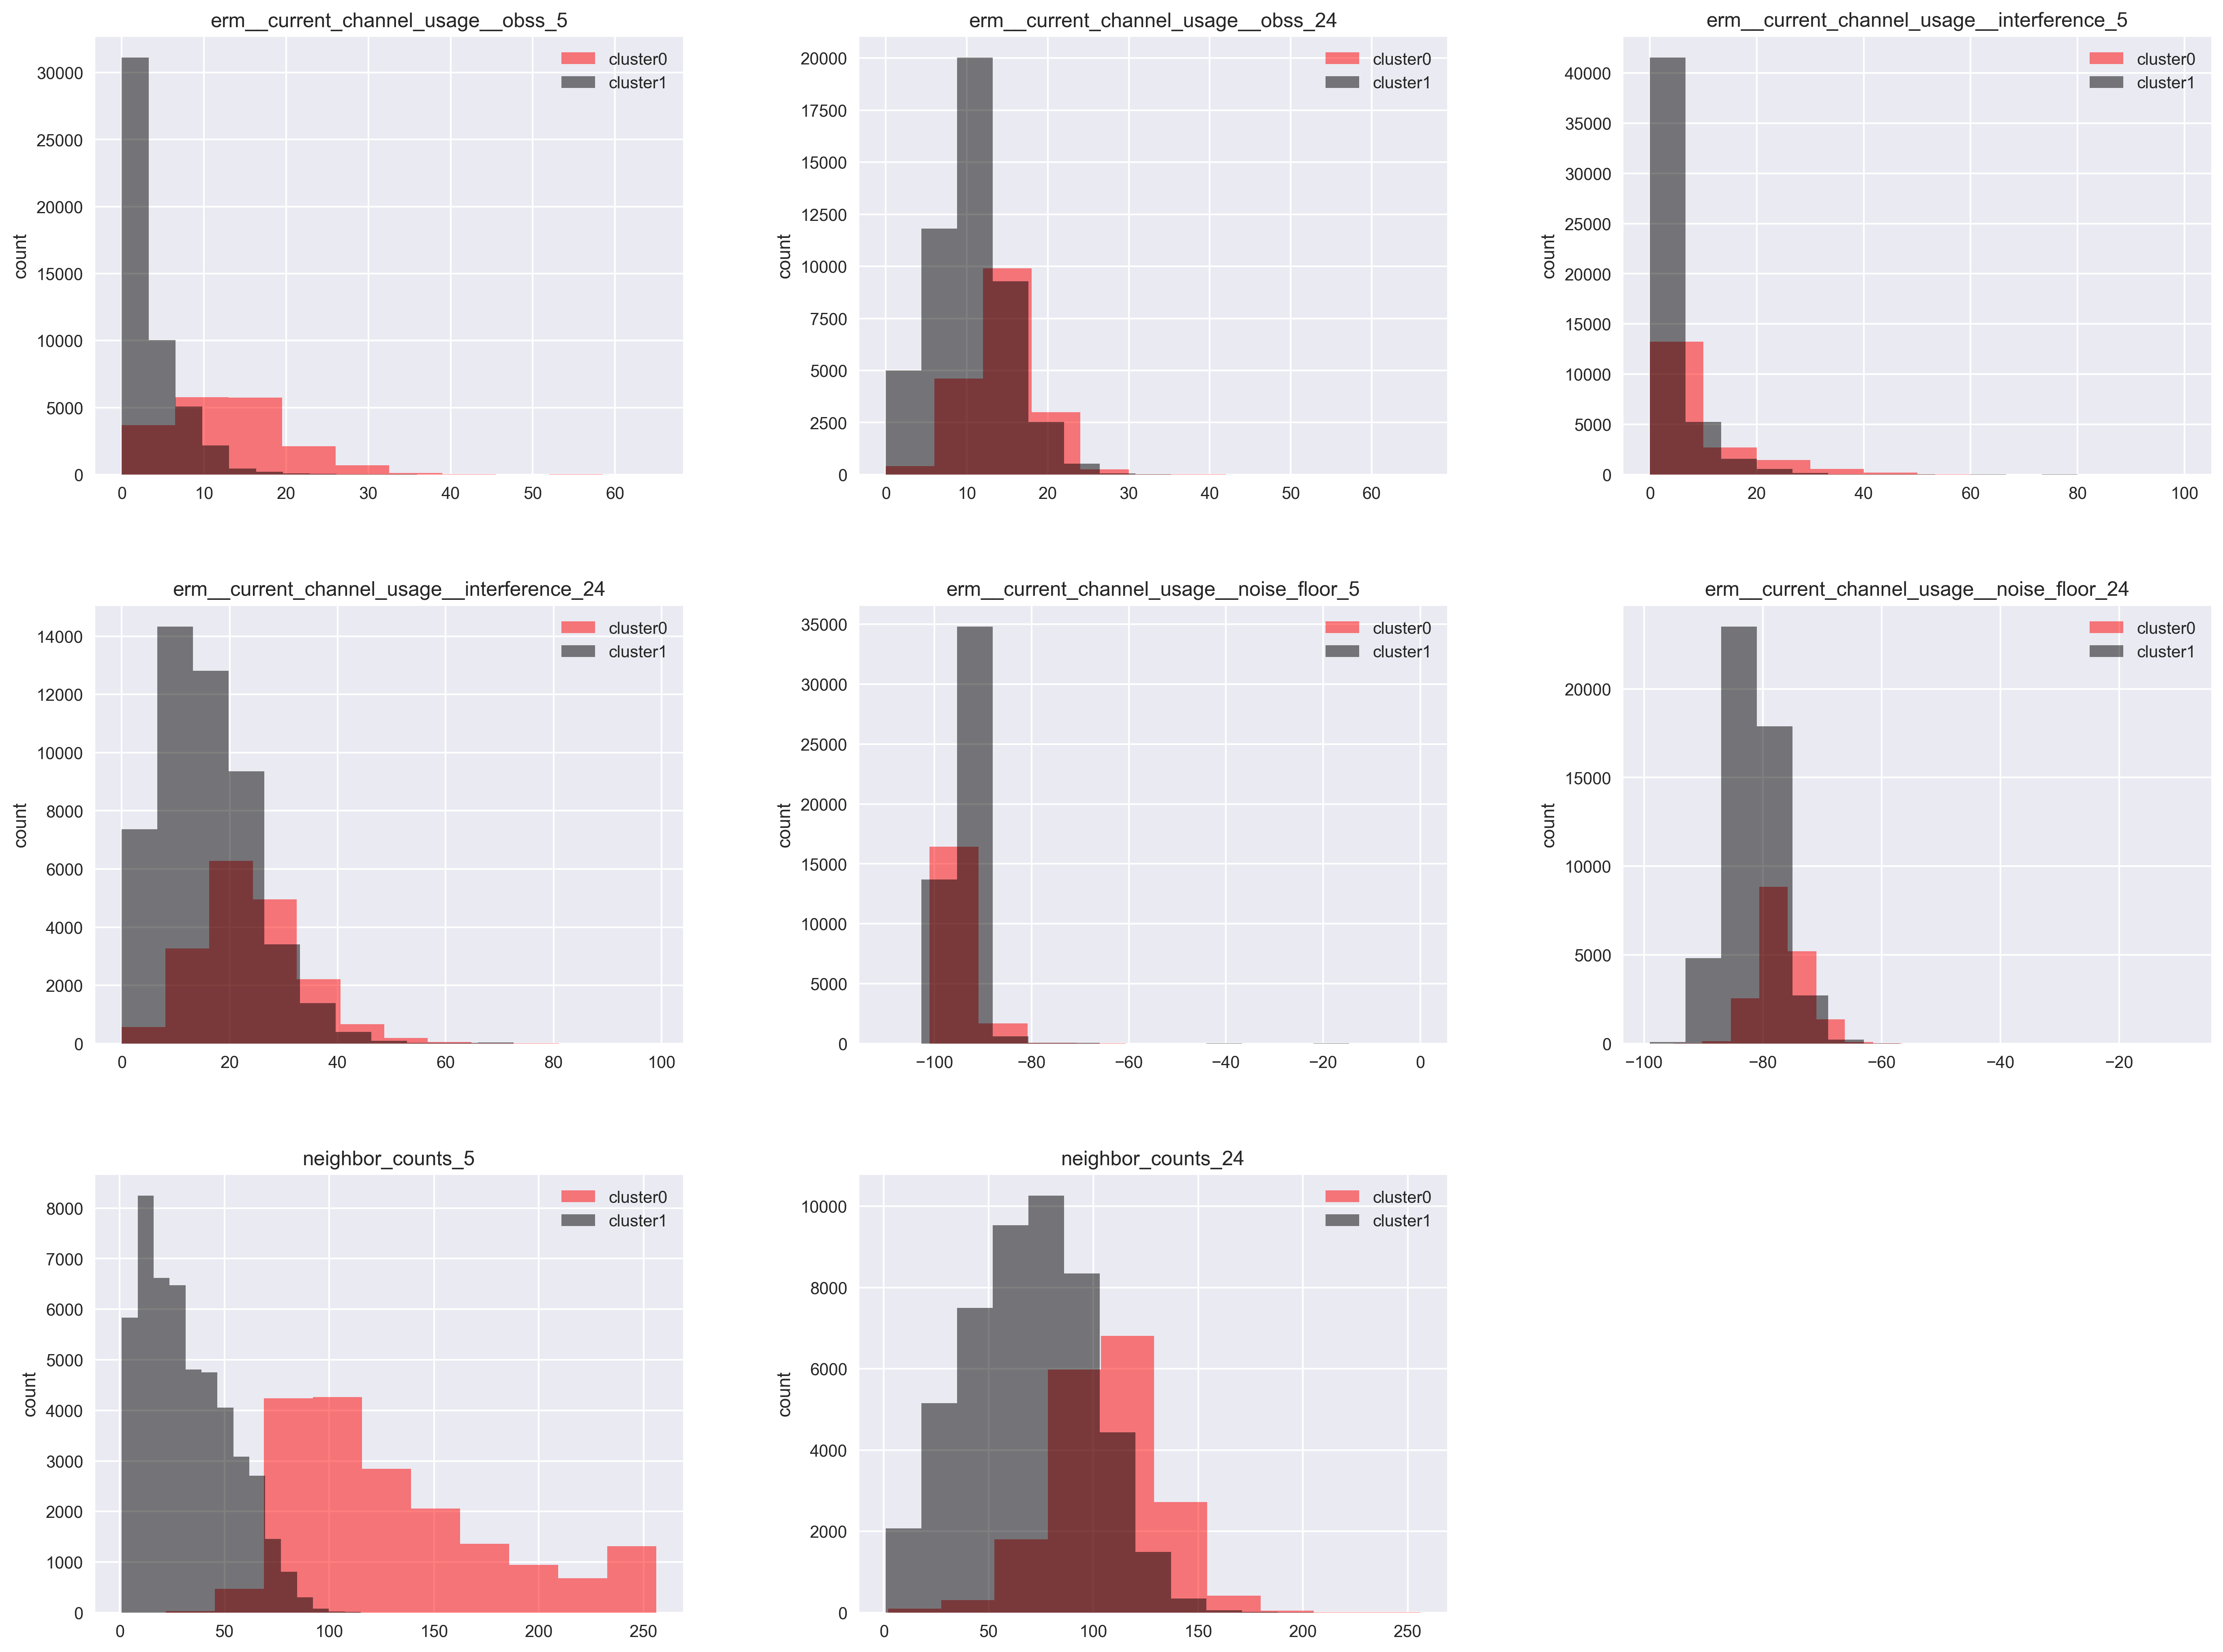

In [277]:
# Plot historgams for each cluster on top of each other
import matplotlib.pyplot as plt

labels = ['cluster0', 'cluster1']
colors = ['r', 'k']
alphalevel = 0.5
binSize = 15
figureSize = (20, 16)

hist = pdCluster0[pdCluster0.columns[3:-2]].hist(alpha = alphalevel, color = colors[0])
for ax, (colname, values) in zip(hist.flat, pdCluster1[pdCluster1.columns[3:-2]].iteritems()):
    values.hist(ax=ax, bins=binSize, figsize = figureSize, alpha = alphalevel, color = colors[1])
    ax.legend(labels)
    ax.set_ylabel('count')
    

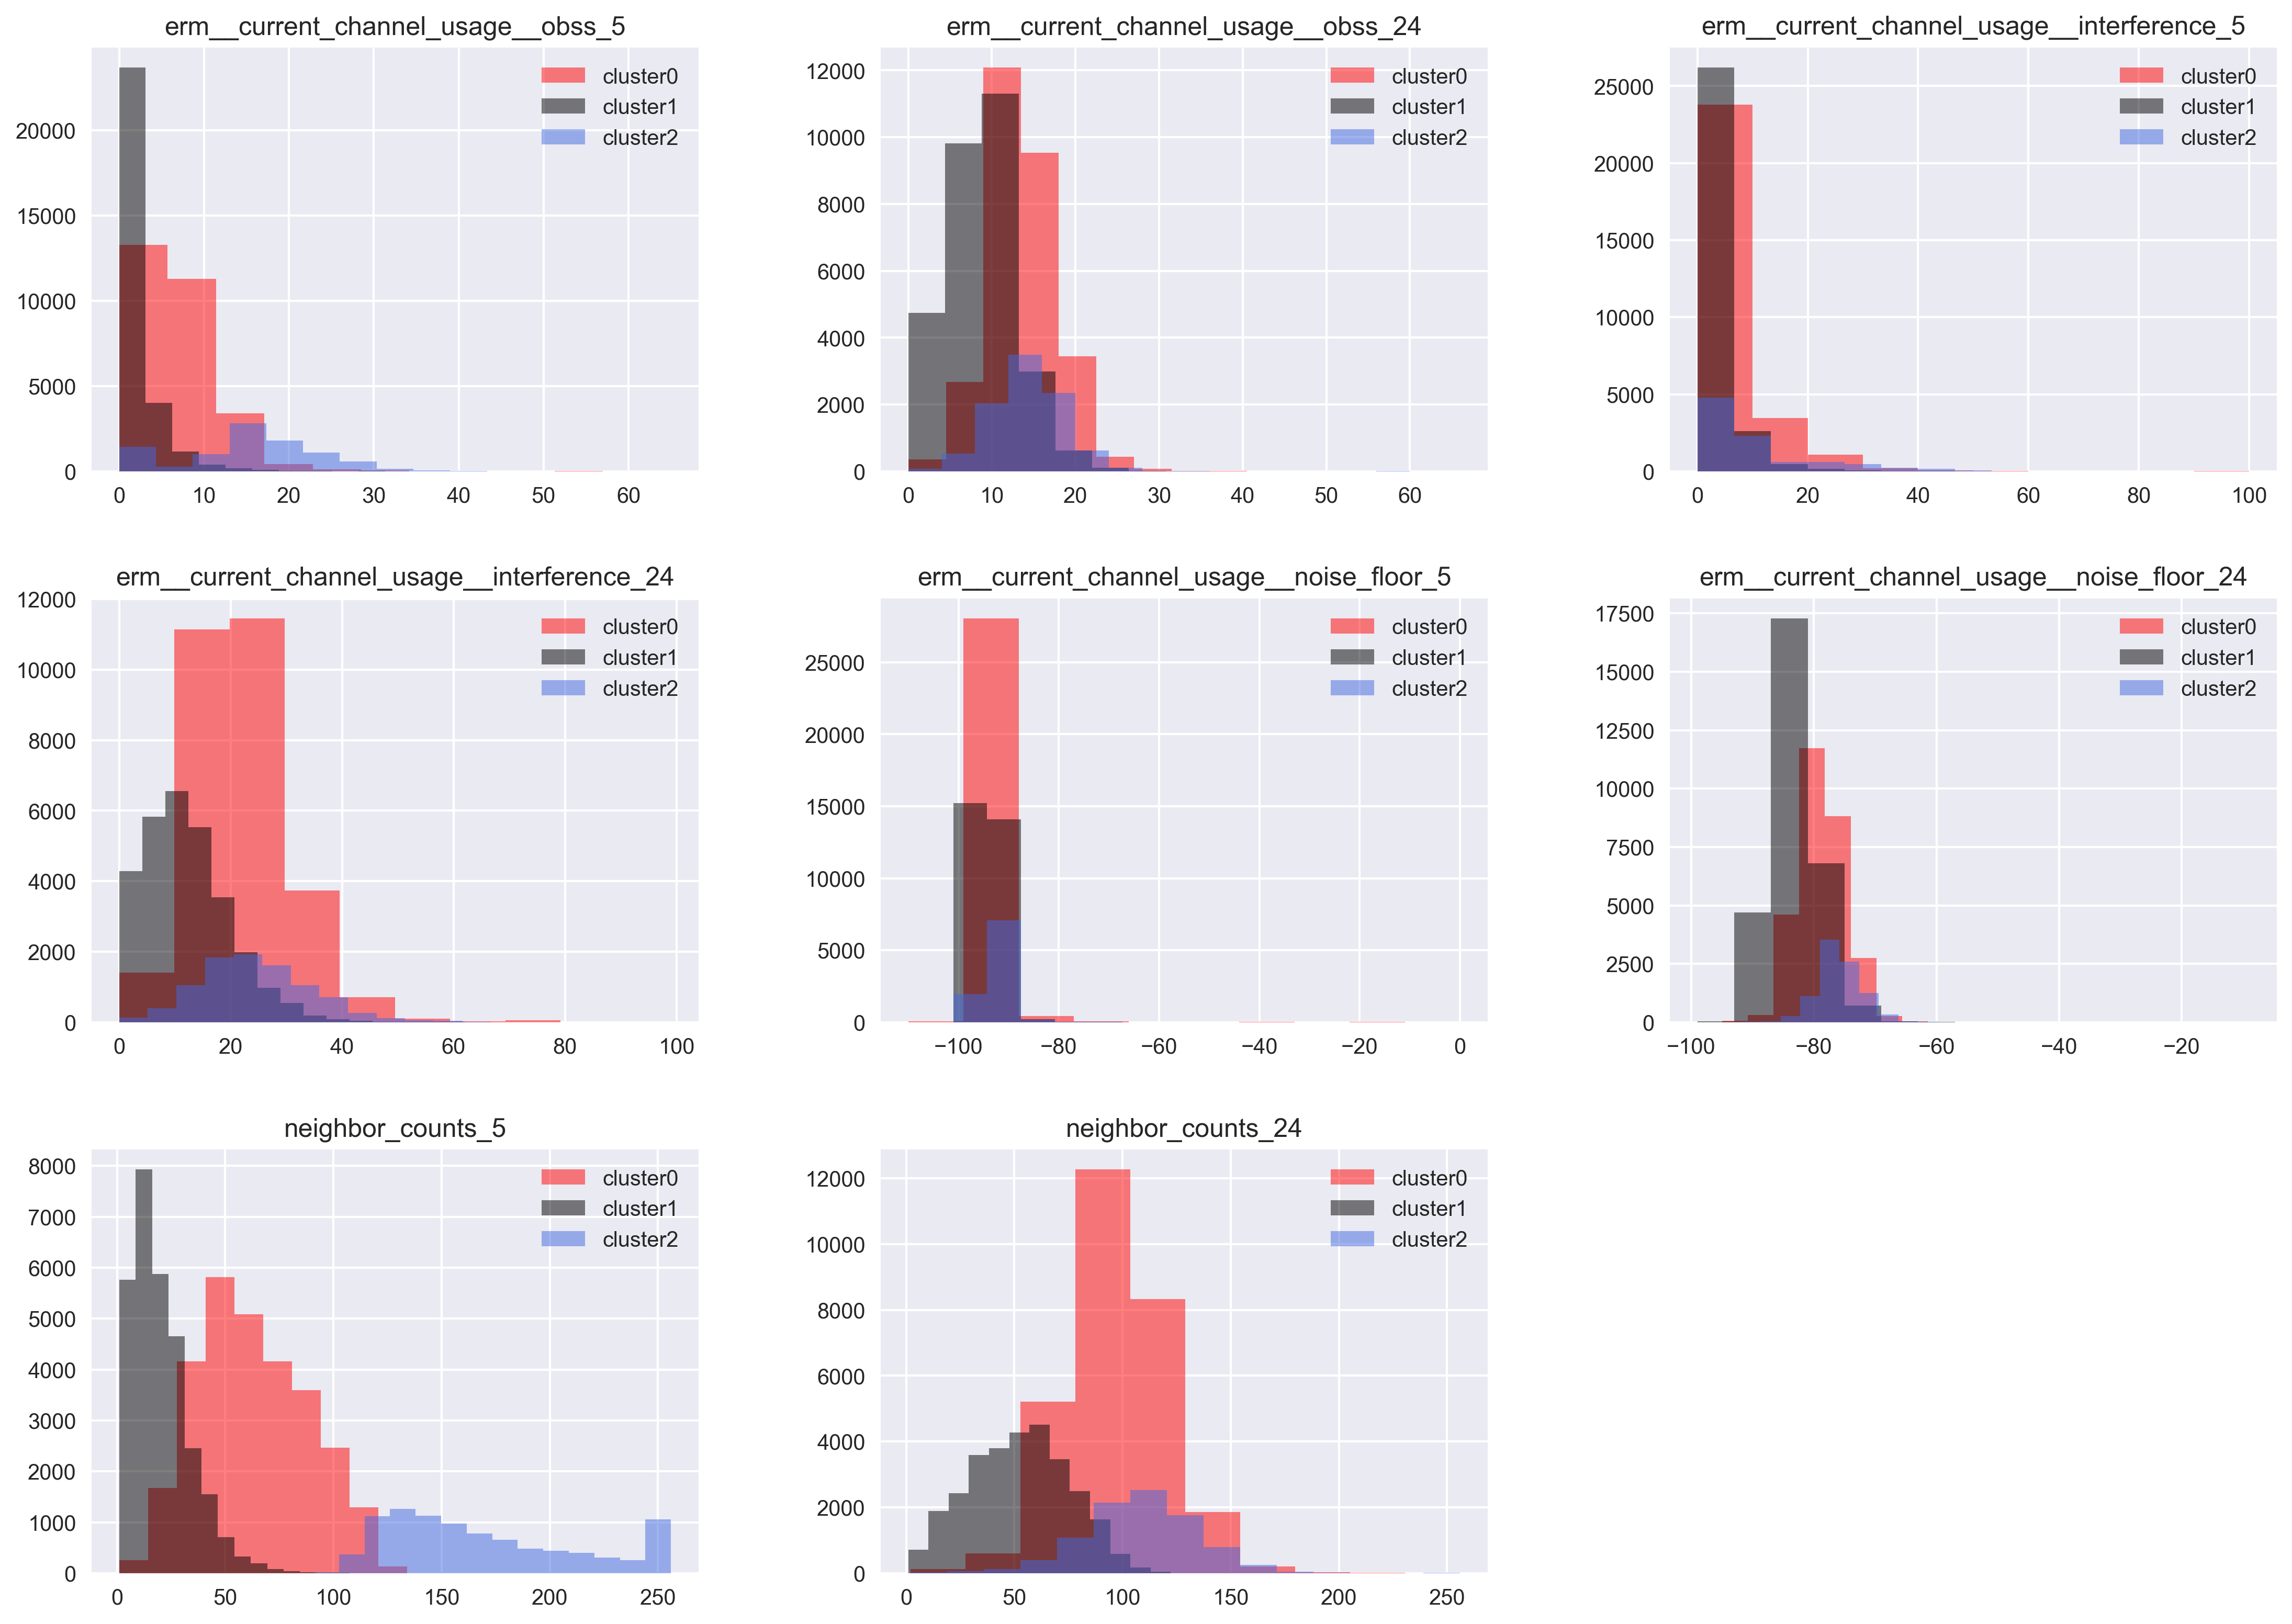

In [271]:
# Plot historgams for each cluster on top of each other
import matplotlib.pyplot as plt

labels = ['cluster0', 'cluster1', 'cluster2']
colors = ['r', 'k', 'royalblue']
alphalevel = 0.5
binSize = 15

figureSize = (16, 12)

hist = pdCluster0[pdCluster0.columns[3:-2]].hist(alpha = alphalevel, color = colors[0])
for ax, (colname, values) in zip(hist.flat, pdCluster1[pdCluster1.columns[3:-2]].iteritems()):
    values.hist(ax=ax, bins=binSize, figsize = figureSize, alpha = alphalevel, color = colors[1])    
    ax.legend(labels)
for ax, (colname, values) in zip(hist.flat, pdCluster2[pdCluster2.columns[3:-2]].iteritems()):
    values.hist(ax=ax, bins=binSize, figsize = figureSize, alpha = alphalevel, color = colors[2])    
    ax.legend(labels)

    

In [196]:
# Calculate cluster intersections for customers
import pandas as pd

cluster0_5 = pd.read_csv('cluster_data/neighbors_5_cluster0.csv')
cluster1_5 = pd.read_csv('cluster_data/neighbors_5_cluster1.csv')
cluster0_24 = pd.read_csv('cluster_data/neighbors_24_cluster0.csv')
cluster1_24 = pd.read_csv('cluster_data/neighbors_24_cluster1.csv')

customers_cluster_0_5 = cluster0_5['customer'] 
customers_cluster_1_5 = cluster1_5['customer'] 
customers_cluster_0_24 = cluster0_24['customer']
customers_cluster_1_24 = cluster1_24['customer']

cluster_sizes = [len(x) for x in [customers_cluster_0_5, customers_cluster_1_5, customers_cluster_0_24, customers_cluster_1_24]]

print('cluster sizes:', cluster_sizes)

# 5 GHz : Cluster 0 - Low, Cluster 1 - High
# 2.4 GHz: Cluster 0 - High, Cluster 1 - Low

intersections = [
    list(set(customers_cluster_0_5) & set(customers_cluster_0_24)), # Cluster 0 (5 GHz) & Cluster 0 (2.4 GHz)
    list(set(customers_cluster_0_5) & set(customers_cluster_1_24)), # Cluster 0 (5 GHz) & Cluster 1 (2.4 GHz)
    list(set(customers_cluster_1_5) & set(customers_cluster_0_24)), # Cluster 1 (5 GHz) & Cluster 0 (2.4 GHz)
    list(set(customers_cluster_1_5) & set(customers_cluster_1_24))  # Cluster 1 (5 GHz) & Cluster 1 (2.4 GHz)
]

intersection_counts = [len(intersection) for intersection in intersections]
print('intersection sizes:', intersection_counts)

cluster sizes: [49112, 13436, 27228, 35272]
intersection sizes: [24913, 22543, 1275, 11829]


[Text(0, 0, 'Intersection (a-c)'),
 Text(1, 0, 'Intersection (a-d)'),
 Text(2, 0, 'Intersection (b - c)'),
 Text(3, 0, 'Intersection (b - d)')]

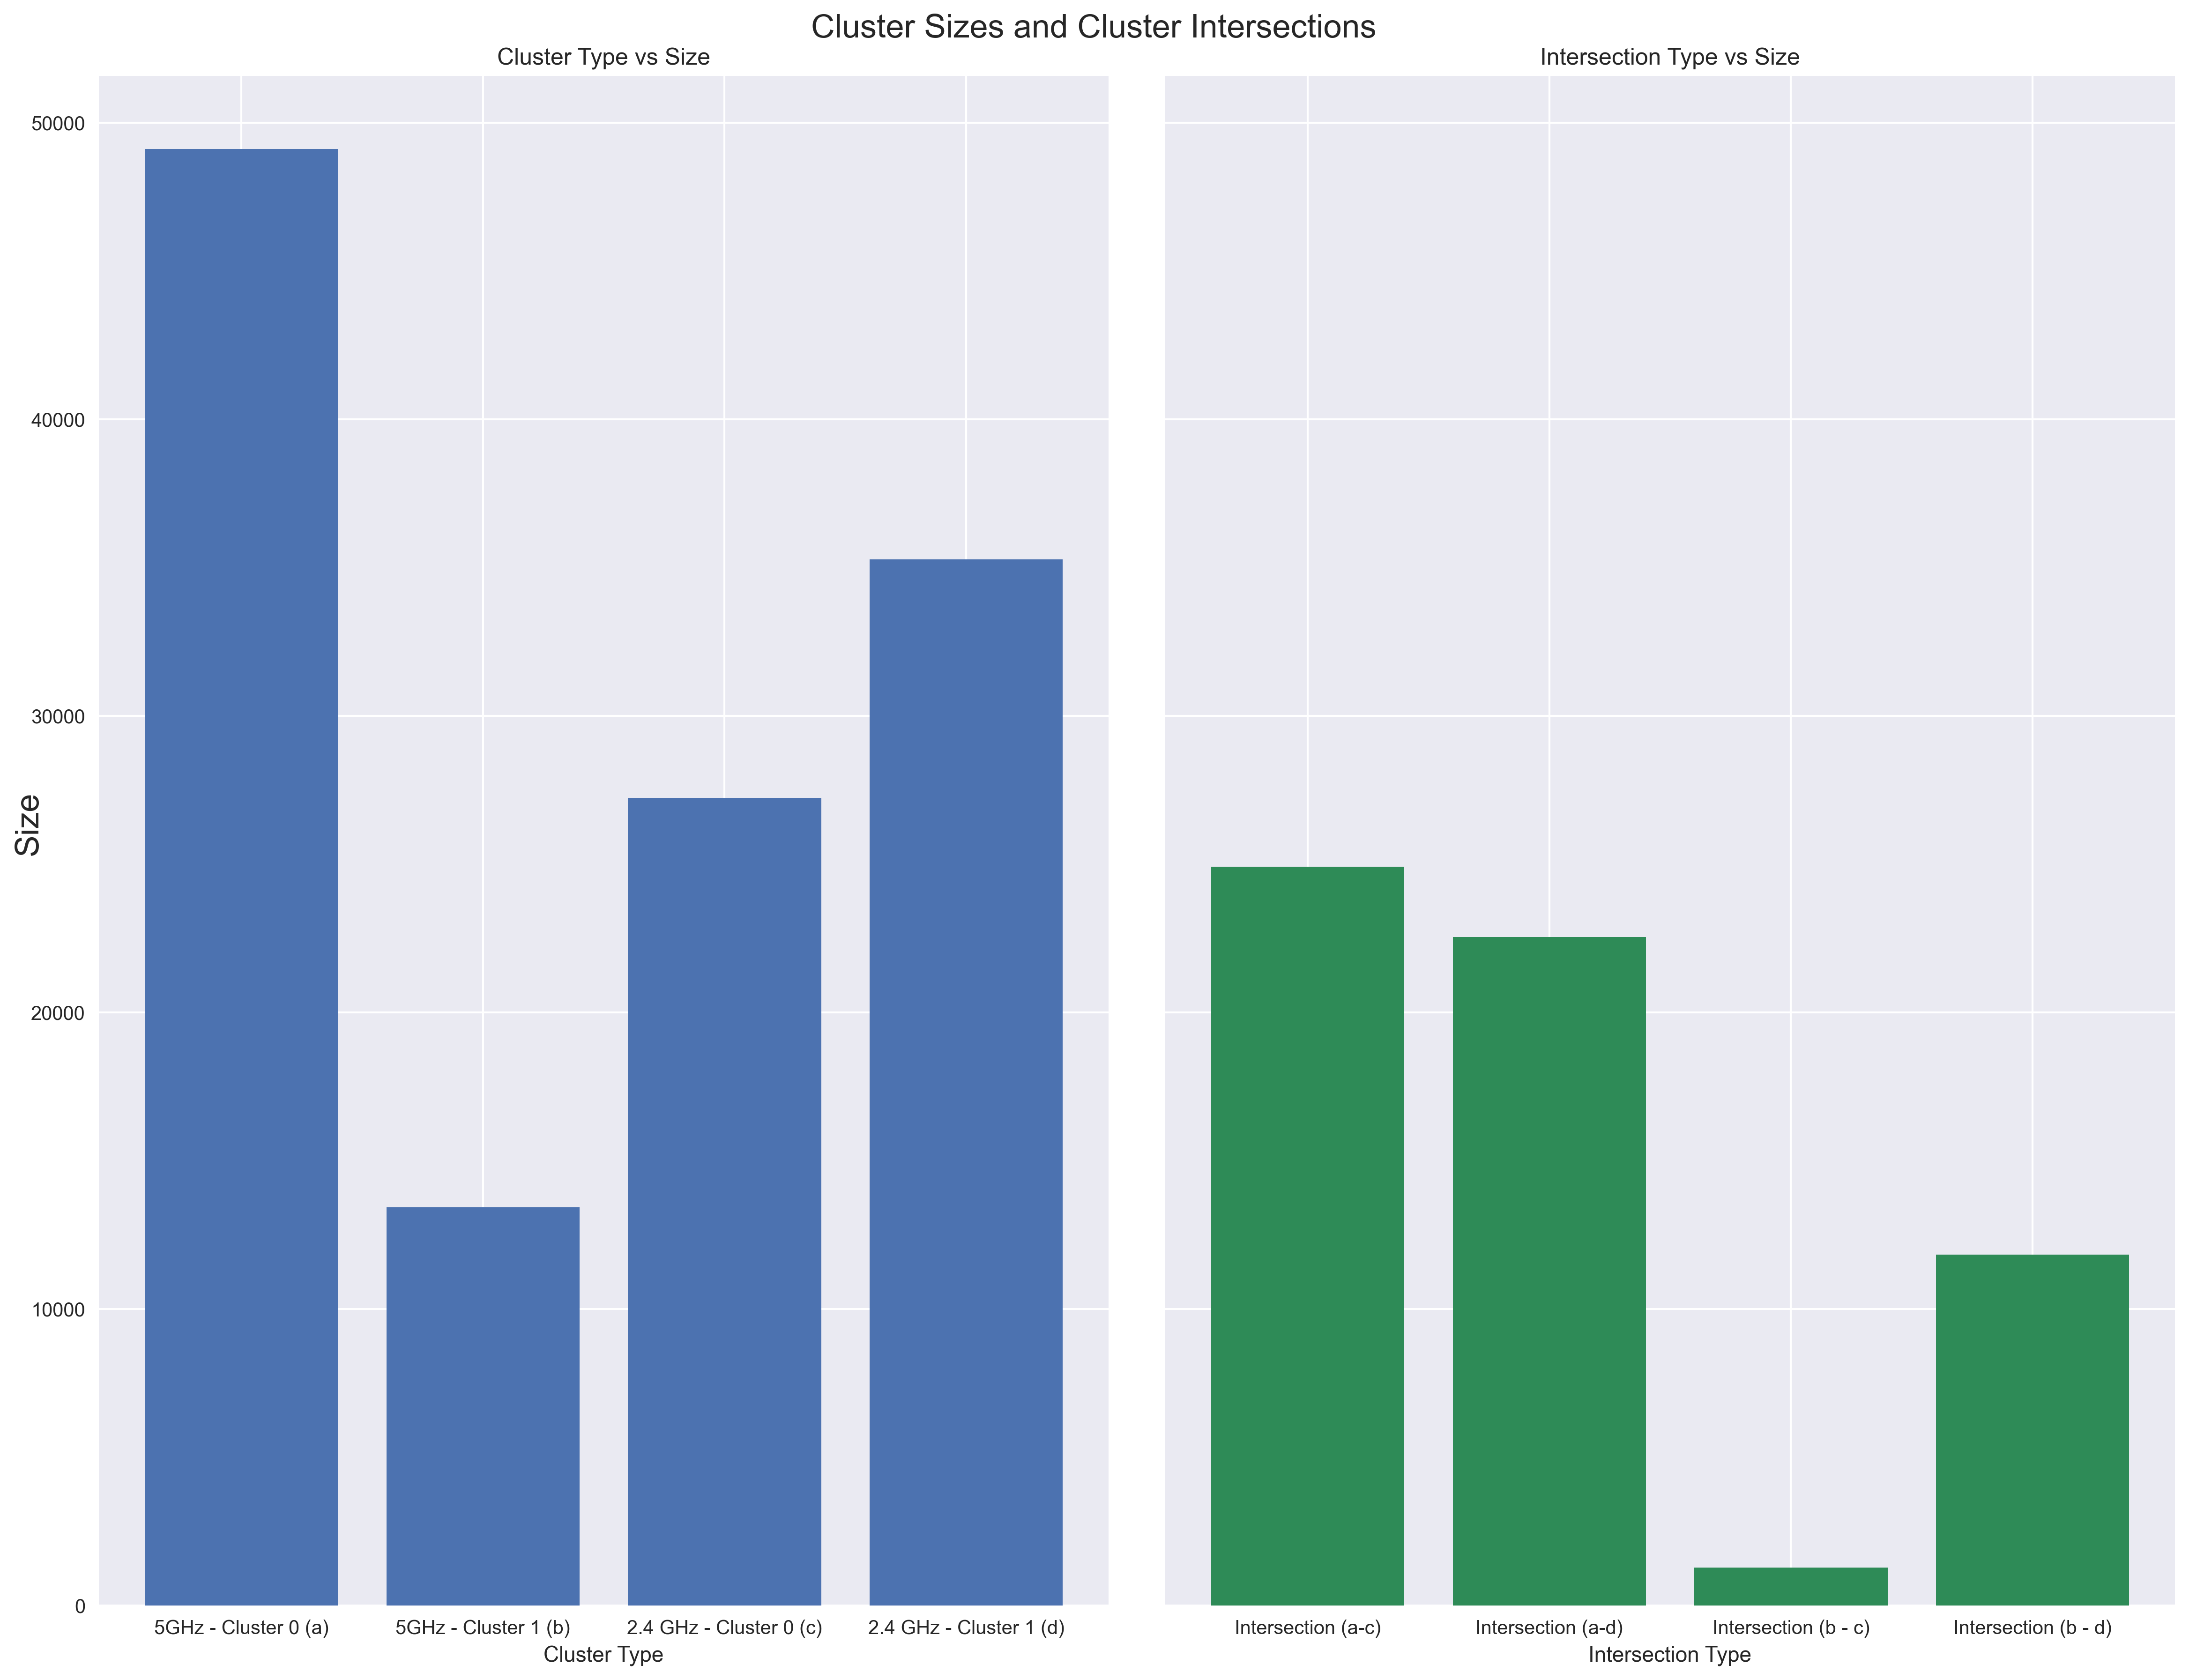

In [270]:
import numpy as np

labels_1 = ['5GHz - Cluster 0 (a)', '5GHz - Cluster 1 (b)', '2.4 GHz - Cluster 0 (c)', '2.4 GHz - Cluster 1 (d)']
labels_2 = ['Intersection (a-c)', 'Intersection (a-d)', 'Intersection (b - c)', 'Intersection (b - d)']
plt.style.use('seaborn')
x = np.arange(len(labels_1))  # the label locations

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 12), sharey = True)
fig.suptitle('Cluster Sizes and Cluster Intersections')
fig.supylabel('Size')
fig.tight_layout()

ax1.bar(x, cluster_sizes)
ax1.set_xlabel('Cluster Type')
ax1.set_title('Cluster Type vs Size')
ax1.set_xticks(x)
ax1.set_xticklabels(labels_1)

ax2.bar(x, intersection_counts, color = 'seagreen')
ax2.set_xlabel('Intersection Type')
ax2.set_title('Intersection Type vs Size')
ax2.set_xticks(x)
ax2.set_xticklabels(labels_2)

In [98]:
# Determine what customers have ids that are split into separate clusters
cluster0_ids = pdCluster0['id_5'].to_list() + pdCluster0['id_24'].to_list()
cluster1_ids = pdCluster1['id_5'].to_list() + pdCluster1['id_24'].to_list()

splitClusterCount = 0

for ids_5, ids_24 in zip(id_list_5, id_list_24):
    clusterNums5 = [0 if id5 in cluster0_ids else 1 for id5 in ids_5]
    clusterNums24 = [0 if id24 in cluster0_ids else 1 for id24 in ids_24]

    if(clusterNums5 != clusterNums24):
        print(id_customer_dict_5[ids_5[0]])
        print('5: ', clusterNums5)
        print('2.4: ', clusterNums24)
        splitClusterCount += 1

{'6edb55e0-2d16-11ea-bdff-4fbc0818d747'}
5:  [0, 1]
2.4:  [1, 0]
{'778c54d0-3c4b-11e9-bb28-79522f2738e7'}
5:  [0, 1]
2.4:  [0, 0]
{'140972d0-261e-11eb-8541-7b9fd2fcac90'}
5:  [0, 1]
2.4:  [0, 0]
{'a3e27930-bff2-11e9-ba8d-5bcdf52cc162'}
5:  [0, 0, 0, 1]
2.4:  [1, 0, 0, 1]
{'a5b706f0-4ff8-11e9-a6e7-15ce71a6e447'}
5:  [0]
2.4:  [0, 0]
{'cab8d280-d3f1-11e9-aa73-a9f835aba4da'}
5:  [0, 1]
2.4:  [1, 0]
{'e6d0dd40-ce89-11e9-b424-9f2d344af1ac'}
5:  [1, 0]
2.4:  [0, 0]
{'bb5d4650-ec28-11e9-92b4-89292aa00c8c'}
5:  [1, 0]
2.4:  [0, 0]
{'edd9a750-2b6f-11ea-925c-cb4788700b86'}
5:  [1, 0]
2.4:  [0, 0]
{'ec03c6c0-37b9-11eb-8c5a-cd1960ca72c5'}
5:  [1, 1]
2.4:  [1]
{'1e65a8c0-d403-11e9-afdd-6d611ee2e607'}
5:  [1, 0]
2.4:  [0, 0]
{'70be42c0-77d4-11e9-a6aa-ef094d1a88ec'}
5:  [1, 0]
2.4:  [0, 0]
{'a6e6fb70-4ff8-11e9-a6e7-15ce71a6e447'}
5:  [0, 1]
2.4:  [0, 0]
{'a10cc0a0-19b3-11eb-8de0-732496e73782'}
5:  [1, 0]
2.4:  [0, 0]
{'87dd2c30-e4f9-11ea-8c51-89caf0bf793b'}
5:  [1, 0]
2.4:  [0, 0]
{'515ede40-0526-11e

In [161]:
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

for k in range(2,10):
    
    kmeans = KMeans(featuresCol='scaled_features', k=k)
    kmModel = kmeans.fit(scaledDF)
    output = kmModel.transform(scaledDF)
    
    score = evaluator.evaluate(output)
    silhouette_score.append(score)
    
    print(k, "Silhouette Score:",score)

2 Silhouette Score: 0.6230767757053167


3 Silhouette Score: 0.4606907211816885


4 Silhouette Score: 0.38791226300568443


5 Silhouette Score: 0.36457424734367583


6 Silhouette Score: 0.36815002086921533


7 Silhouette Score: 0.3335562703694673


8 Silhouette Score: 0.28243508514879107


9 Silhouette Score: 0.28207518585642716


/var/folders/yn/m0pbsyzn6kz3jdnb9f75twwr0000gp/T/ipykernel_54051/713746461.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png') #png


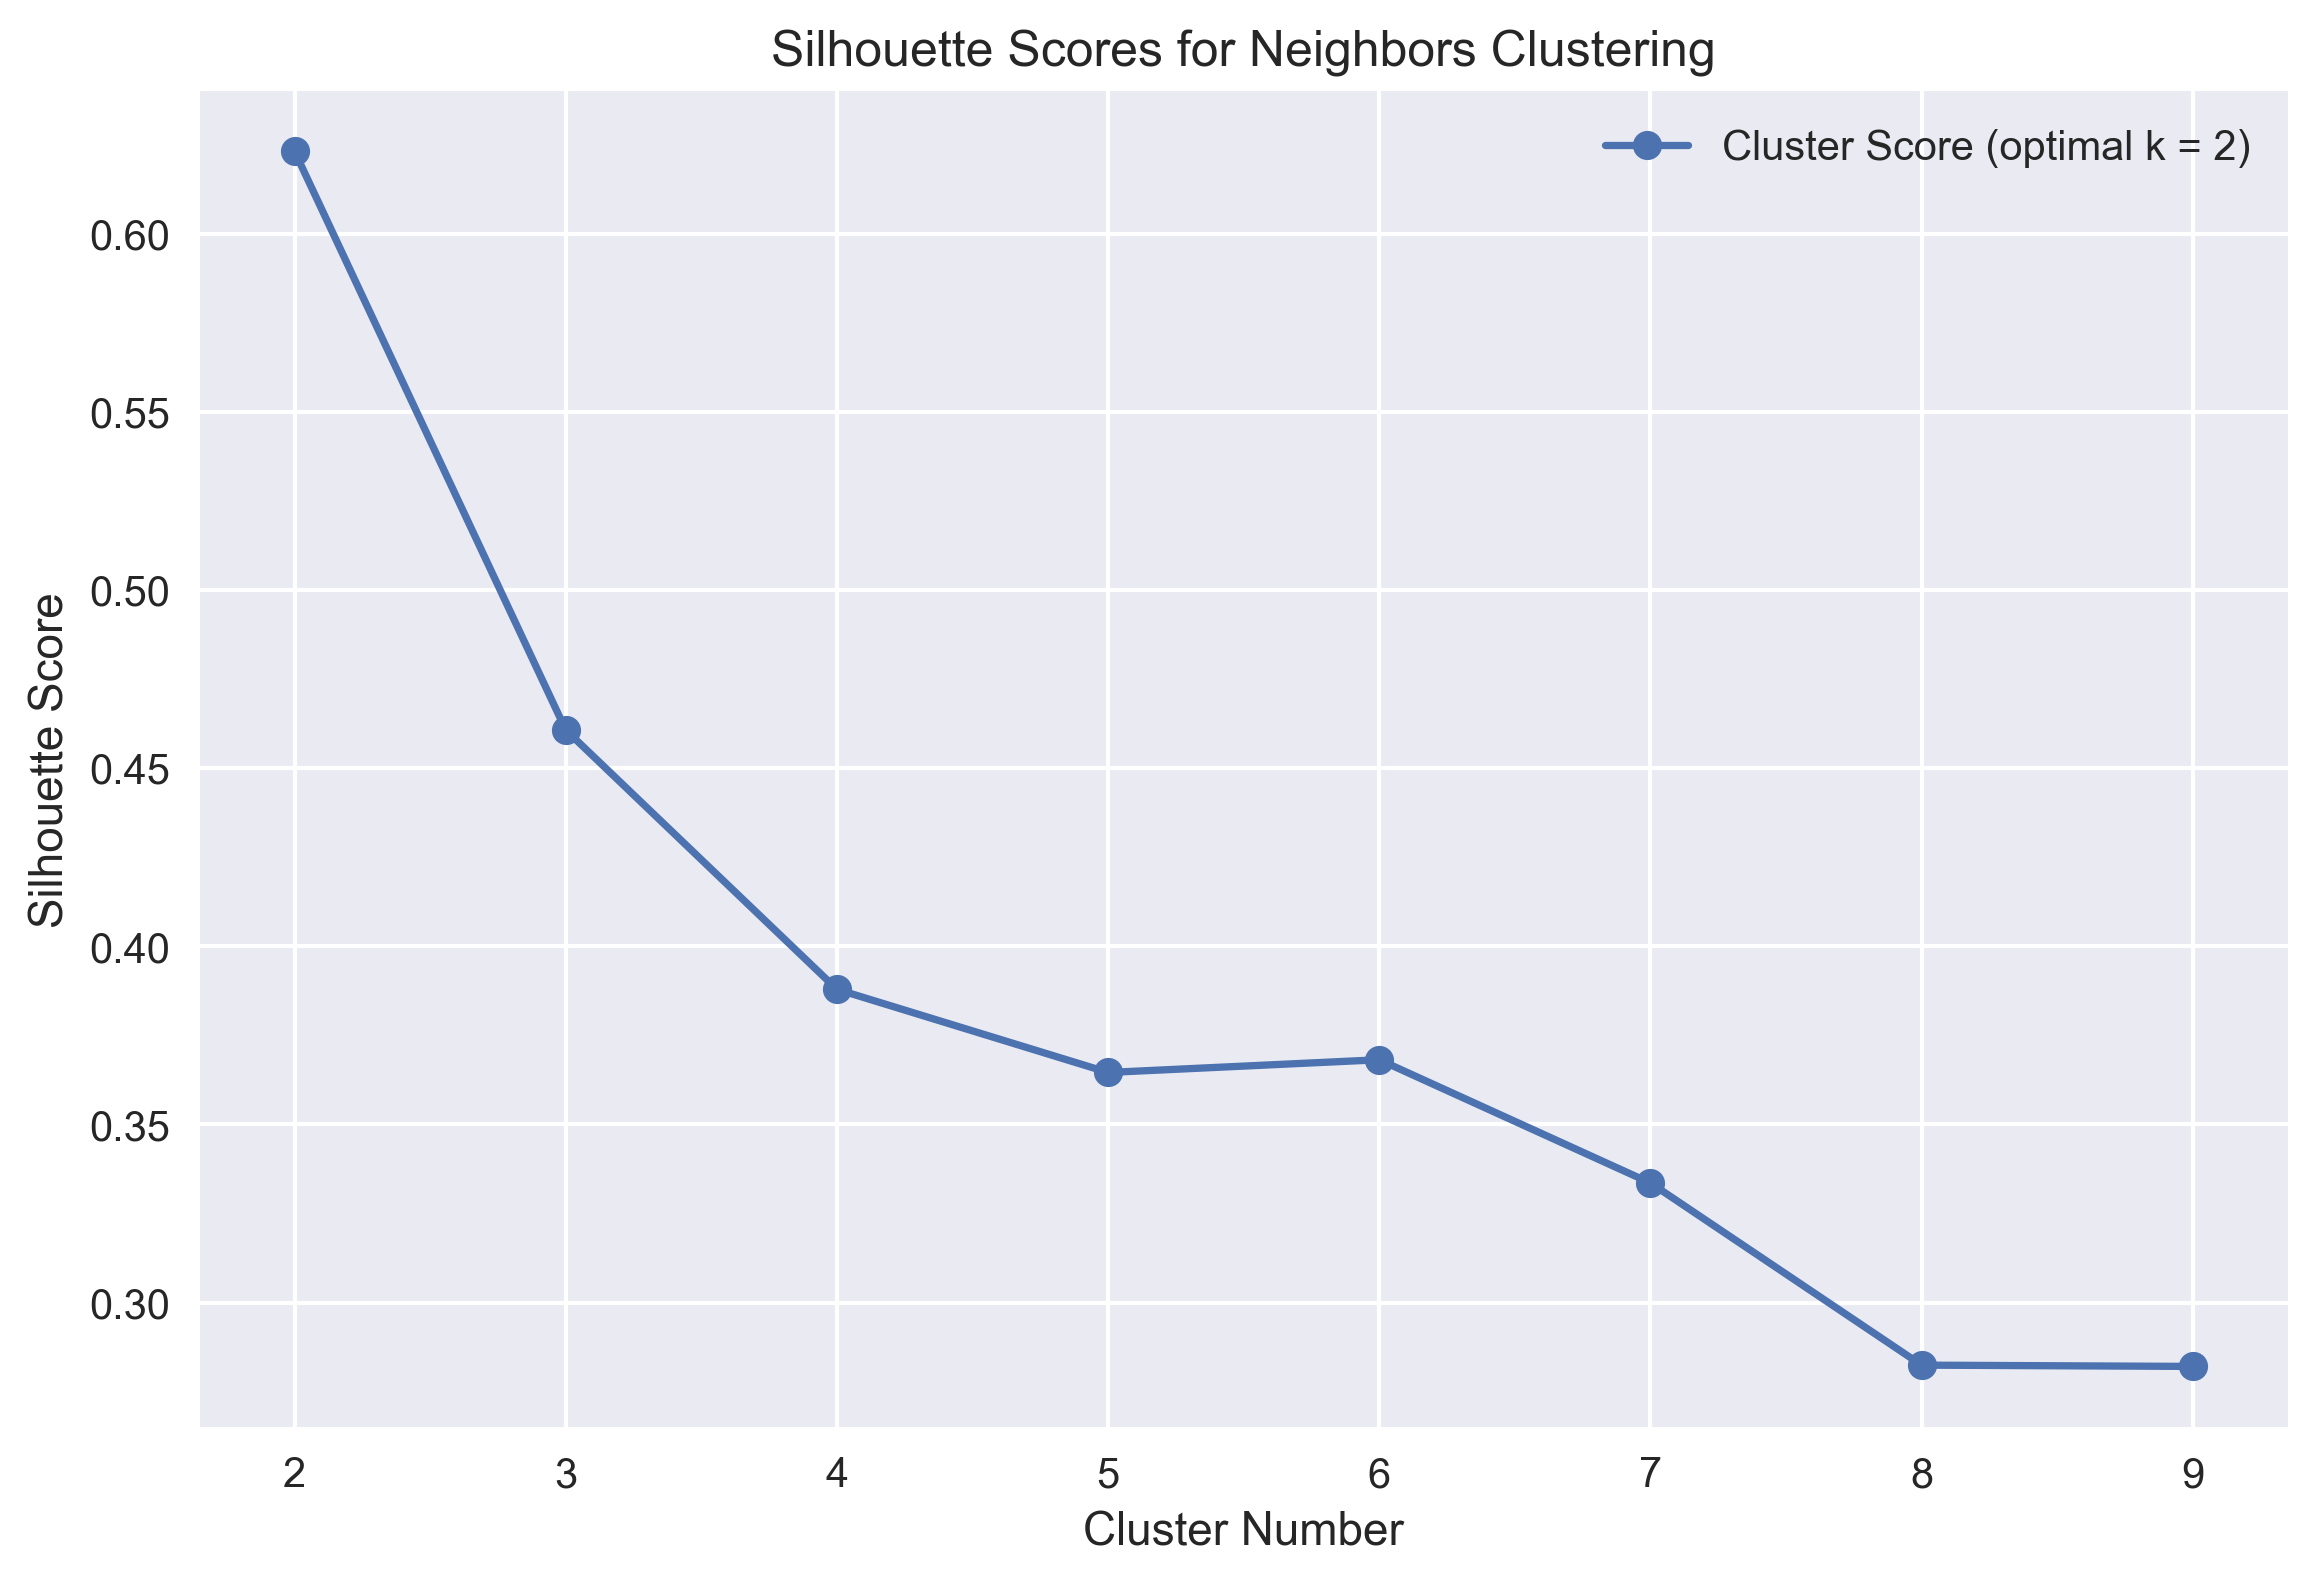

In [269]:
# Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png') #png
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.style.use('seaborn')
plt.title('Silhouette Scores for Neighbors Clustering')
plt.xlabel('Cluster Number')
plt.ylabel('Silhouette Score')
plt.plot(range(2,10), silhouette_score, marker = 'o', label = 'Cluster Score (optimal k = 2)', antialiased = True)
plt.legend()
plt.show()